In [11]:
import pandas as pd
import numpy as np
import os
from dateutil.parser import parse
from pandas.tseries.offsets import BDay
import pickle
import fnmatch
import datetime as dt
from datetime import timedelta
import glob
#Set PANDAS to show all columns in DataFrame
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
def listdirs(folder): #return only directories from a master folder
    return [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]

def find_path(basepath, stringname):
    for fname in os.listdir(basepath):
        path = os.path.join(basepath, fname)
        if os.path.isdir(path):
            if stringname in fname:
                return path
def get_ticket(rx_path):
    ticker=rx_path.split(".")[0].split("/")[-1].split("-")[0]
    return ticker

def ticker_trades_dir(ticker):
    dest=os.path.join(os.getenv('FINANCE_DATA'), "_".join((ticker,'trades')))
    if not os.path.isdir(dest):
        os.makedirs(dest)
def quotes_trades_dir(ticker):
    dest=os.path.join(os.getenv('FINANCE_DATA'), "_".join((ticker,'quotes')))
    if not os.path.isdir(dest):
        os.makedirs(dest)
def agg_on_trd_time(gr):
    """
    Utility func to aggregate trades on timestamp. All trades with equal time stamp
    will collapse to one row and the traded price will be the volume weighted traded
    price.
    """
    vTrdPrice = np.sum(gr['TradedPrice'] * gr['Volume'])/np.sum(gr['Volume'])
    volume = np.sum(gr['Volume'])

    return pd.Series({'Volume': volume,
                      'TradedPrice': vTrdPrice})

def open_pickle_file(path, pickle_file):
    file_loc = os.path.join(path, pickle_file)
    pickle_to_file = pickle.load(open(file_loc, "rb"))
    return pickle_to_file
def common_member(a, b): 
      
    a_set = set(a) 
    b_set = set(b) 
      
    # check length  
    if len(a_set.intersection(b_set)) > 0: 
        return(a_set.intersection(b_set))   
    else: 
        return("no common elements") 

def f(x):
     return Series(dict(Number_of_tweets = x['content'].count(), 
                        Company=x['Company'].min(),
                        Description=x['from_user_description'].min(),
                        ))
    
def obv_calc(df):
    df['SignedVolume']=df['Volume']*np.sign(df['TradedPrice'].diff()).cumsum()
    df['SignedVolume'][:1]=0
    df['OBV']=df['SignedVolume'].cumsum()
    df =df.drop(columns=['SignedVolume'])
    return df
def chaikin_mf(df, period=5):
    df["MF Multiplier"] = (df['TradedPrice']-(df['TradedPrice'].expanding(period).min() ) \
                           - (df['TradedPrice'].expanding(period).max() - df['TradedPrice']))/(df['TradedPrice'].expanding(period).max() - df['TradedPrice'].expanding(period).min())
    df["MF Volume"] = df['MF Multiplier'] * df['Volume'] 
    df['CMF']= df['MF Volume'].sum()/df["Volume"].rolling(5).sum()
    df=df.drop(columns=['MF Multiplier','MF Volume'])
    return df

In [77]:
def plot(data):
    plt.figure(figsize=(16,4))

    plt.subplot(1, 2, 1)
    plt.scatter(data["x"], data["y"])
    plt.xlabel("x")
    plt.ylabel("y")

    plt.subplot(1, 2, 2)
    plt.scatter(data["x"], data["z"])
    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()
def transform_to_uniform(x):
    tmp = x.argsort()
    cdf = np.zeros(tmp.shape)
    cdf[tmp] = np.arange(len(x))
    return cdf / len(x)

In [84]:
size = 2000

def generate_plots(data):
    plt.figure(figsize=(20,4))

    plt.subplot(1, 4, 1)
    plt.hist2d(data[:,0], data[:,1], density=True, vmin=0, vmax=1)
    c = plt.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.colorbar(c)
    plt.title("Real")

    plt.subplot(1, 4, 2)
    try:
        copula = Clayton()
        copula.fit(data)
        synthetic = copula.sample(len(data))
        plt.hist2d(synthetic[:,0], synthetic[:,1], density=True, vmin=0, vmax=1)
        plt.colorbar();
        plt.title("Clayton")
    except:
        print("Skipping Clayton...")

    plt.subplot(1, 4, 3)
    try:
        copula = Gumbel()
        copula.fit(data)
        synthetic = copula.sample(len(data))
        plt.hist2d(synthetic[:,0], synthetic[:,1], density=True, vmin=0, vmax=1)
        plt.colorbar();
        plt.title("Gumbel")
    except:
        print("Skipping Gumbel...")


    plt.subplot(1, 4, 4)
    try:
        copula = Frank()
        copula.fit(data)
        synthetic = copula.sample(len(data))
        plt.hist2d(synthetic[:,0], synthetic[:,1], density=True, vmin=0, vmax=1)
        plt.colorbar();
        plt.title("Frank")
    except:
        print("Skipping Frank...")

    plt.show()

In [2]:
##locations ##
dataOnlyDrive = ('/media/ak/WorkDrive/Data')
''' Exterrnal Files'''
extPath = '/media/ak/My Passport/Experiment Data'
barketData = '/media/ak/My Passport/Barket Data/'

In [3]:
targetDrive = barketData
bmrg_folders=[s for s in os.listdir(targetDrive ) if s.endswith('Comdty')]
bmrg_trades=sorted([s for s in os.listdir(targetDrive ) if s.endswith('y_trades')])
bmrg_quotes=sorted([s for s in os.listdir(targetDrive ) if s.endswith('y_quotes')])
bmrg_tickers=sorted([bmrg_trades[idx].split('_t')[0] for idx,_ in enumerate(bmrg_trades)])

In [4]:
# symbols = ['FB1', 'TU1', 'TY1', 'FV1']
print(bmrg_quotes, bmrg_trades)

['TY1_Comdty_quotes', 'US1_Comdty_quotes'] ['TY1_Comdty_trades', 'US1_Comdty_trades']


In [5]:
bmrg_tickers

['TY1_Comdty', 'US1_Comdty']

In [6]:
symbolIdx= 0
# get dates and files
symbol_quotes = os.path.join(targetDrive,str(bmrg_quotes[symbolIdx]))
symbol_trades = os.path.join(targetDrive,str(bmrg_trades[symbolIdx]))
symbolQuoteDates = [quoteFile.split(".")[0] for quoteFile in os.listdir(symbol_quotes)] 
symbolTradeDates = [tradeFile.split(".")[0] for tradeFile in os.listdir(symbol_trades)] 

In [7]:
# TradeQuoteDates =[set(ymQuoteDates).intersection(set(ymTradeDates))]
symbol_quotes


'/media/ak/My Passport/Barket Data/TY1_Comdty_quotes'

In [ ]:
# tradeTestDate = os.path.join(symbol_trades, quoteTradeDates[0]+'.csv')
# tradeQuoteDate = os.path.join(symbol_quotes, quoteTradeDates[0]+'.csv')
# trades =pd.read_csv(tradeTestDate,low_memory=False)
# quotes = pd.read_csv(tradeQuoteDate, low_memory=False)

In [35]:
# #create dictionaries that have all the data we may need/want. on for top of the LOB and one for trades
# quoteTradeDates=[eventDate for eventDate in symbolQuoteDates if eventDate in symbolTradeDates]
# len(quoteTradeDates)
# dfAllTrades ={}
# dfAllQuotes ={}
# for idx,date in enumerate(quoteTradeDates):
#     tradeTestDate = pd.read_csv(os.path.join(symbol_trades, quoteTradeDates[idx]+'.csv'))
#     tradeQuoteDate = pd.read_csv(os.path.join(symbol_quotes, quoteTradeDates[idx]+'.csv'))
#     dfAllTrades[date] = tradeTestDate
#     dfAllQuotes[date] = tradeQuoteDate
    
    

In [8]:
dfAllQuotesName = "".join(('AllQuotes',bmrg_quotes[symbolIdx],'Comdty.pkl'))
dfAllTradesName = "".join(('AllTrades',bmrg_trades[symbolIdx],'Comdty.pkl'))

In [9]:
os.path.isfile("/".join((symbol_quotes, dfAllQuotesName)))
allQuotesDict =open_pickle_file(symbol_quotes, dfAllQuotesName)

In [13]:
allTradesDict = open_pickle_file(symbol_trades, dfAllTradesName)

pkl.dump(dfAllQuotes, open("/".join((symbol_quotes, dfAllQuotesName)), "wb"))


pkl.dump(dfAllTrades, open("/".join((symbol_trades, dfAllTradesName)), "wb"))

In [14]:
dQuoteKeys = list(allQuotesDict.keys()) #one common set of keys at the moment
dTradeKeys = list(allTradesDict.keys())
commonDates =list(set(dQuoteKeys).intersection(set(dTradeKeys)))


In [45]:
allQuotesDict[dQuoteKeys[1]]

,Unnamed: 0,size,time,type,value
0,0,1319,2018-04-16 00:00:00,BID,120.375000
1,1,427,2018-04-16 00:00:00,ASK,120.390625
2,2,425,2018-04-16 00:00:00,ASK,120.390625
3,3,350,2018-04-16 00:00:00,ASK,120.390625
4,4,1320,2018-04-16 00:00:00,BID,120.375000
...,...,...,...,...,...
852509,886104,728,2018-04-17 00:00:00,ASK,120.453125
852510,886105,1191,2018-04-17 00:00:00,BID,120.437500
852511,886106,1190,2018-04-17 00:00:00,BID,120.437500
852512,886107,1192,2018-04-17 00:00:00,BID,120.437500


In [18]:
# 
# dfLOBRaw={}
# QuoteColumns =['Unnamed: 0','TimeStamp']
# TradeColumns= ['Unnamed: 0', 'size', 'time', 'type', 'value']
dKeys= commonDates
for idx, dateKey in enumerate(commonDates):
    #dfAllQuotes[dKeys[idx]].reset_index(level=0, inplace=True)
    allQuotesDict[dKeys[idx]]['TimeStamp']= pd.to_datetime(allQuotesDict[dKeys[idx]]['time'])
    allTradesDict[dKeys[idx]]['TradeTimeStamp']= pd.to_datetime(allTradesDict[dKeys[idx]]['time'])
    allTradesDict[dKeys[idx]]['TradedPrice']= allTradesDict[dKeys[idx]]['value']
    allTradesDict[dKeys[idx]]['TradedSize']= allTradesDict[dKeys[idx]]['size']
    allTradesDict[dKeys[idx]].rename(columns = {'type':'QuotedSide','value':'bestPrice','size':'QuoteSize','time':'QuoteTimeStamp'}, inplace = True) 
    allTradesDict[dKeys[idx]]['Duration']=allTradesDict[dKeys[idx]].TradeTimeStamp.diff()/np.timedelta64(1, 'ms')
    
    

In [34]:
commonKeys =list(set(allTradesDict).intersection(set(allQuotesDict)))

In [39]:
idxKey=1
dfBID=allQuotesDict[commonKeys[idxKey]][allQuotesDict[commonKeys[idxKey]]['type']=='BID'].rename(columns={'type':'BidSide','value':'bestBidPrice','size':'bestBidSize','time':'TimeStampS'})
dfASK=allQuotesDict[commonKeys[idxKey]][allQuotesDict[commonKeys[idxKey]]['type']=='ASK'].rename(columns={'type':'BidSide','value':'bestBidPrice','size':'bestBidSize','time':'TimeStampS'})
#  =dfAllQuotes[commonDates[idx]][dfAllQuotes[commonDates[idx]]['type']=='BID'].rename(columns={'type':'BidSide','value':'bestBidPrice','size':'bestBidSize','time':'TimeStampS'})#.drop(QuoteColumns, inplace=True, axis=1)
# dfASK =dfAllQuotes[commonDates[idx]][dfAllQuotes[commonDates[idx]]['type']=='ASK'].rename(columns={'type':'AskSide','value':'bestAskPrice','size':'bestAskSize','time':'TimeStampS'})#.drop(QuoteColumns, inplace=True, axis=1)

In [54]:
idx=1
# dfBID =dfAllQuotes[commonDates[idx]][dfAllQuotes[commonDates[idx]]['type']=='BID'].rename(columns={'type':'BidSide','value':'bestBidPrice','size':'bestBidSize','time':'TimeStampS'})#.drop(QuoteColumns, inplace=True, axis=1)
# dfASK =dfAllQuotes[commonDates[idx]][dfAllQuotes[commonDates[idx]]['type']=='ASK'].rename(columns={'type':'AskSide','value':'bestAskPrice','size':'bestAskSize','time':'TimeStampS'})#.drop(QuoteColumns, inplace=True, axis=1)
dfLOB =dfBID.merge(dfASK,left_on='TimeStampS', right_on='TimeStampS')
# dfLOB= dfLOB.drop(['Unnamed: 0_x', 'Unnamed: 0_y','AskSide','BidSide'], axis=1)
#dfAllTrades[dKeys[0]].TradeTimeStamp.diff().dropna()/np.timedelta64(1, 'ms')

In [60]:
dfLOB.columns.values

array(['Unnamed: 0_x', 'bestBidSize_x', 'TimeStampS', 'BidSide_x',
       'bestBidPrice_x', 'TimeStamp_x', 'Unnamed: 0_y', 'bestBidSize_y',
       'BidSide_y', 'bestBidPrice_y', 'TimeStamp_y'], dtype=object)

In [62]:
allTradesDict[commonDates[idx]] = allTradesDict[commonDates[idxKey]].rename(index=str, columns={"QuoteSize": "TradedVolume","TradeTimeStamp":"TimeStampS"}).drop(columns=['Unnamed: 0'])

In [63]:
dfClean = allTradesDict[commonDates[idx]].rename(index=str)

In [36]:
# dfMergedLOB = dfBID.merge(dfASK,left_on='TimeStampS', right_on='TimeStampS')

In [71]:
dfClean['TradedPriceChange'] =dfClean.TradedPrice.pct_change()
dfClean=dfClean.dropna()

/home/ak/Envs/resrPyth3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [80]:
x= dfClean.TradedPriceChange.values
y= dfClean.Duration
z= dfClean.TradedVolume

NameError: name 'z_min' is not defined

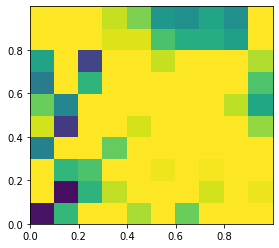

In [85]:
data = np.stack([transform_to_uniform(z), transform_to_uniform(y)], axis=1)
generate_plots(data)

In [ ]:
# dfLOBraw ={}
# for idx, dateKey in enumerate(commonDates):
#     dfBID =dfAllQuotes[dKeys[idx]][dfAllQuotes[dKeys[0]]['type']=='BID'].rename(columns={'type':'BidSide','value':'bestBidPrice','size':'bestBidSize','time':'BidTimeStamp'})
#     dfASK =dfAllQuotes[dKeys[idx]][dfAllQuotes[dKeys[0]]['type']=='ASK'].rename(columns={'type':'AskSide','value':'bestAskPrice','size':'bestAskSize','time':'AskTimeStamp'})
#     dfLOBraw[dKeys[idx]] =pd.concat([dfBID, dfASK],axis=1, join='outer')

In [27]:
idx=0
dfBID =dfAllQuotes[dKeys[idx]][dfAllQuotes[dKeys[idx]]['type']=='BID'].rename(columns={'type':'BidSide','value':'bestBidPrice','size':'bestBidSize','time':'BidTimeStamp'})#.drop(QuoteColumns, inplace=True, axis=1)
dfASK =dfAllQuotes[dKeys[idx]][dfAllQuotes[dKeys[idx]]['type']=='ASK'].rename(columns={'type':'AskSide','value':'bestAskPrice','size':'bestAskSize','time':'AskTimeStamp'})#.drop(QuoteColumns, inplace=True, axis=1)
dfAllTrades[dKeys[0]].TradeTimeStamp.diff().dropna()/np.timedelta64(1, 'ms')
#dfAllQuotes[dateKeys[idx]]['Time']= dfAllQuotes[dateKeys[idx]]['time'].dt.time
    
    

NameError: name 'dfAllQuotes' is not defined

In [26]:
dfAllTrades[dKeys[0]].TradeTimeStamp.diff().dropna()/np.timedelta64(1, 'ms')

NameError: name 'dfAllTrades' is not defined

In [ ]:
columns = ['index', 'Unnamed: 0','time','AskSide']


In [36]:
# dfBID =dfAllQuotes[dKeys[0]][dfAllQuotes[dKeys[0]]['type']=='BID'].rename(columns={'type':'BidSide','value':'bestBidPrice','size':'bestBidSize','TimeStamp':'BidTimeStamp'})
# dfASK =dfAllQuotes[dKeys[0]][dfAllQuotes[dKeys[0]]['type']=='ASK'].rename(columns={'type':'AskSide','value':'bestAskPrice','size':'bestAskSize','TimeStamp':'AskTimeStamp'})

In [ ]:
dfASK.head(3)

In [ ]:
columns = [ 'Unnamed: 0','TimeStamp','AskSide']
dfASK.drop(columns, inplace=True, axis=1)
dfASK.head(3)

In [24]:
columns = [ 'Unnamed: 0','TimeStamp','BidSide']
dfBID.drop(columns, inplace=True, axis=1)
dfBID.head(3)

NameError: name 'dfBID' is not defined

In [23]:
dfLOBraw =pd.concat([dfBID, dfASK],axis=1, join='outer').ffill().dropna()
dfLOBraw.tail(125)

NameError: name 'dfBID' is not defined

In [ ]:
tp_rolling=test_file['TradedPrice'].rolling(5).mean()
v= test_file['Volume'].rolling(5).mean()
df=test_file
# df.groupby(df.index).rolling(7).apply(lambda x: np.average(x.TradedPrice, weights=x.Volume))

In [ ]:
# # Groupby column with rolling mean.
# df_grouped_rolling = df.groupby(df.index)[['TradedPrice', 'Volume']].rolling(window=3, min_periods=2).min()
# df_grouped_rolling.groupby(df_grouped_rolling.index).rolling(7).apply(lambda x: np.average(x.TradedPrice, weights=x.Volume))
# # # df_grouped_rolling.head(10)
# df_grouped_rolling

In [ ]:
# idx=0
# trades_files_loc = os.path.join(data_dir,bmrg_trades[idx])
# trades_files= os.listdir(os.path.join(data_dir,bmrg_trades[idx]))
# # file_idx=1
# for file_idx,_ in enumerate(trades_files):
#     symbol='G_1_Comdty'
#     print('working on symbol:', symbol)
#     trades_df = pd.read_csv(os.path.join(trades_files_loc, trades_files[file_idx]), index_col=0)
#     print('reading this:', trades_files[file_idx])
#     trades_df=trades_df.rename(index=str, columns={"size": "Volume","value":"TradedPrice"}).drop(columns=['type'])
#     trades_df['TradedTime'] = pd.to_datetime(trades_df['time'])
#     trades_df= trades_df.drop(columns=['time'])
#     res = trades_df.groupby('TradedTime').apply(agg_on_trd_time)
#     res.reset_index(inplace=True)
#     res.loc[:, 'Duration'] = res['TradedTime']- res['TradedTime'].shift(1)
#     res['Duration'].fillna(value=0, inplace=True)
#     res.loc[:, 'Duration'] = res['Duration'].apply(lambda tt: tt.total_seconds())
#     res.loc[1:, 'ReturnTradedPrice'] = \
#         res['TradedPrice'].rolling(window=2).apply(lambda xx: np.log(xx[-1]/xx[0]))
#     res.loc[0, 'ReturnTradedPrice'] = 0.
#     target_file_name
#     target_file_name = os.path.join(os.path.join(data_dir,symbol),trades_files[file_idx])
#     print('saving here:', target_file_name)karima
#     res[['TradedTime', 'TradedPrice', 'ReturnTradedPrice', 'Volume', \
#          'Duration']].to_csv(target_file_name, index=False)
# print(res.columns.values)                       

In [ ]:
# for idx, symbol_trades in enumerate(bmrg_trades):
#     trades_files_loc = os.path.join(data_dir,bmrg_trades[idx])
#     trades_files= os.listdir(os.path.join(data_dir,bmrg_trades[idx]))
#     symbol="_".join((bmrg_trades[idx].split('_')[0],"Comdty"))
#     print('working on symbol:', symbol)
#     for file_idx,_ in enumerate(trades_files):
#         print('reading this:', trades_files[file_idx])
#         trades_df = pd.read_csv(os.path.join(trades_files_loc, trades_files[file_idx]), index_col=0)
#         trades_df=trades_df.rename(index=str, columns={"size": "Volume","value":"TradedPrice"}).drop(columns=['type'])
#         trades_df['TradedTime'] = pd.to_datetime(trades_df['time'])
#         trades_df= trades_df.drop(columns=['time'])
#         res = trades_df.groupby('TradedTime').apply(agg_on_trd_time)
#         res.reset_index(inplace=True)
#         res.loc[:, 'Duration'] = res['TradedTime']- res['TradedTime'].shift(1)
#         res['Duration'].fillna(value=0, inplace=True)
#         res.loc[:, 'Duration'] = res['Duration'].apply(lambda tt: tt.total_seconds())
#         res.loc[1:, 'ReturnTradedPrice'] = \
#             res['TradedPrice'].rolling(window=2).apply(lambda xx: np.log(xx[-1]/xx[0]))
#         res.loc[0, 'ReturnTradedPrice'] = 0
#         target_file_name = os.path.join(os.path.join(data_dir,symbol),trades_files[file_idx])
#         print('saving here:', target_file_name)
#         res[['TradedTime', 'TradedPrice', 'ReturnTradedPrice', 'Volume', \
#              'Duration']].to_csv(target_file_name, index=False)

        
    


In [ ]:
# symbol_path = find_path(data_dir, str(bmrg_symbols[0]))
# symbol_files=os.listdir(symbol_path)

# symbol=symbol_files[1].split('-')[0]
# date=symbol_files[1].split('-')[1].split('.')[0]
idx=3
trades_loc= os.path.join(data_dir,bmrg_trades[1])
list_files =os.listdir(os.path.join(data_dir,bmrg_trades[1]))
trades_file = os.path.join(trades_loc, list_files[idx])
df= pd.read_csv(trades_file,index_col=0 )
df.drop(columns=['type'])

In [ ]:
from dateutil.parser import parse
import datetime as dt
# sample = parse(df['time'].iloc[:,1])
# print(sample)
sample=parse(df['time'].iloc[12])
# # datetime.datetime(2010, 2, 15, 0, 0)
# print(dt.strftime('%d/%m/%Y'))
# # 15/02/2010
sample_time=sample.time()
sample_time.strftime('%H:%M:%S.%f')

# Crypto Data#

In [ ]:
import os
crypto=os.path.join(data_only_drive,'crypto/BTCUSD.PERP.BMEX')
os.listdir(data_only_drive)

In [ ]:
crypto_path=os.path.join(data_only_drive,'crypto')
trades_crypto_path = os.path.join(crypto_path,'trades')
perp_trades_loc= os.path.join(trades_crypto_path,'BTCUSD.PERP.BMEX')
perp_trades_list=os.listdir(perp_trades_loc)

In [ ]:
LOB = os.path.join(crypto_path,'LOB')
lob_files= os.listdir(os.path.join(LOB,os.listdir(LOB)[0]))


In [ ]:
sample_file = pd.read_csv(os.path.join(perp_trades_loc, perp_trades_list[0]), index_col=0)

In [ ]:
os.path.join(perp_trades_loc, perp_trades_list[0])

In [ ]:
sample_file.reset_index(inplace=True)

In [ ]:
from scipy.spatial.distance import pdist, squareform

In [ ]:
sample_file=sample_file.drop(columns=['index'])

In [ ]:
sample_file.columns.values

In [ ]:
crypto_df= pd.to_datetime(sample_file['received_at'])

In [ ]:
crypto_df['TradedPrice']= sample_file['price']


In [ ]:
sample_file =sample_file.rename(index=str, columns={"received_at":"TradedTime","side":"Side"})

In [ ]:
sample_file['TradedTime']=pd.to_datetime(sample_file['TradedTime'])

In [ ]:
sample_file =sample_file.rename(index=str, columns={"price":"TradedPrice","size":"Volume"})

In [ ]:
def get_time(date_time):
    timestamp= date_time.strftime('%H:%M:%S.%f')
    return timestamp

In [ ]:
sample_file['TradedTime']=sample_file['TradedTime'].apply(get_time)

res = sample_file.groupby('TradedTime').apply(agg_on_trd_time)
res.reset_index(inplace=True)
res.loc[:, 'Duration'] = res['TradedTime']- res['TradedTime'].shift(1)
res['Duration'].fillna(value=0, inplace=True)
res.loc[:, 'Duration'] = res['Duration'].apply(lambda tt: tt.total_seconds())
res.loc[1:, 'ReturnTradedPrice'] = \
res['TradedPrice'].rolling(window=2).apply(lambda xx: np.log(xx[-1]/xx[0]))
res.loc[0, 'ReturnTradedPrice'] = 0

In [ ]:
data_dir = os.getenv('FINANCE_DATA') #main directory
data_only_drive= '/mnt/usb-Seagate_Expansion_Desk_NA8XEHR6-0:0-part2'
bmrg_symbols=[s for s in os.listdir(data_dir) if s.endswith('20181028') or s.endswith('20181027')]


bmrg_symbols_destinations=[s for s in os.listdir(data_dir) if s.endswith('trades') or s.endswith('quotes')]
bmrg_tickers=[bmrg_symbols_destinations[idx].split('_t')[0] or \
              bmrg_symbols_destinations[idx].split('_q')[0] for idx,_ in enumerate(bmrg_symbols_destinations)]
ftse_symbols= [s for s in os.listdir(data_dir) if s.endswith('.L')]
features_models_dd= os.path.join(data_dir, 'features_models')
labels = os.path.join(features_models_dd, 'labels')
model_features= os.path.join(features_models_dd, 'features')
features_models_dOd= os.path.join(data_only_drive, 'features_models')

In [ ]:
data_dir
ftse_symbols= [s for s in os.listdir(data_dir) if s.endswith('.L')]
test=os.listdir(os.path.join(data_dir, ftse_symbols[1]))
len(test)

In [ ]:

for idx,_ in enumerate(ftse_symbols):
    symbol=ftse_symbols[idx] # set symbol
    features_models_path = '/media/ak/WorkDrive/Data/features_models/models/'
    features_only_path = '/media/ak/WorkDrive/Data/features_models/features/'
    symbol_raw_data_path = os.listdir(os.path.join(data_dir, symbol))
    symbol_hmm_model_path = os.listdir(os.path.join(features_models_path, symbol,'HMM'))
    symbol_labels_path= os.listdir(os.path.join(labels, symbol,'NON_DIRECTIONAL')) # set labels path for the symbol
    market_features_path = os.listdir(os.path.join(data_only_drive,'Data','features_models',symbol,'MARKET_BASED'))
    symbol_model_features = os.listdir(os.path.join(features_only_path, symbol, 'MODEL_BASED'))
#     print('symbol: ', symbol)
# #     print('number of days: ', len(symbol_raw_data_path))
# #     print('number of hmm models: ', len(symbol_hmm_model_path))
# #     print("number of date files in labels:",len(symbol_labels_path))
#     print("mearket features:", len(market_features_path))
#     print("common elements between market features and labels:",len(list(common_member(market_features_path, \
#                                                                                        symbol_labels_path))))
# #     if len(symbol_raw_data_path)!= len(symbol_labels_path):
# #         print('check symbol:',symbol)
# #         problem_list.append(symbol)


In [ ]:
##test case##
symbol='AAL.L' # set symbol
features_models_path = '/media/ak/WorkDrive/Data/features_models/models/'
symbol_raw_data_path = os.path.join(data_dir, symbol)
symbol_hmm_model_path = os.path.join(features_models_path, symbol,'HMM')
symbol_labels_path= os.path.join(labels, symbol,'NON_DIRECTIONAL') # set labels path for the symbol
market_features_path = os.path.join(data_only_drive,'Data','features_models',symbol,'MARKET_BASED')
print('symbol: ', symbol)
print(symbol_raw_data_path)
print(symbol_hmm_model_path)
print(symbol_labels_path)
print(market_features_path)


In [ ]:
symbol_features = os.listdir(os.path.join(features_only_path, symbol, 'MODEL_BASED')) #this is a list of folders, indexed by date
labels_dates= [symbol_labels_path[idx].split(".")[0] for idx, _ in enumerate(symbol_labels_path)]
date=labels_dates[1]
# for _, date in enumerate(labels_dates):
date_symbol_features = os.path.join(features_only_path, symbol, 'MODEL_BASED', date)
date_feature_list= os.listdir(date_symbol_features)
for idx, _ in enumerate(date_feature_list):
    open_pickle_file(path=date_symbol_features, pickle_file=date_feature_list[idx])


In [ ]:
date
date_symbol_features = os.path.join(features_only_path, symbol, 'MODEL_BASED', date)
date_symbol_features
date_feature_list= os.listdir(date_symbol_features)
print date_feature_list
for idx, _ in enumerate(date_feature_list):
     open_pickle_file(path=date_symbol_features, pickle_file=date_feature_list[idx])[1]

In [ ]:
# for idx, date  in enumerate(symbol_model_features):
#     print os.listdir(os.path.join(features_only_path, symbol, 'MODEL_BASED', date))
date_feature_list= os.listdir(date_symbol_features)
for idx, _ in enumerate(date_feature_list):
    print date_feature_list[idx]

In [ ]:
duration=pd.read_csv(file_location,index_col=0)['Duration']
non_directional_labels = pd.read_csv(file_location,index_col=0)['label_PrMov__window_25__thres_arbitrary__10.0'] #this is a problem
df = pd.read_csv(file_location,index_col=0)
features_dates_dir= os.listdir(symbol_features_path)#
# path for a specific hmm model date --- out of sample pickle files
pickle_features_path= os.path.join(symbol_features_path, features_dates_dir[1])

In [ ]:
os.listdir(pickle_features_path)

In [ ]:
# 'III.L_3_states_features_date:_20171024_now:_20181226_
compute_date= '20181226'
date= features_dates_dir[5]
features_pickle_file = "_".join((symbol,'3_states_features_date:',features_dates_dir[5],'now:',compute_date,'.pickle'))

In [ ]:
model_features =open_pickle_file(pickle_features_path,features_pickle_file) #tuple for all the HMM- model features

In [ ]:
market_features_path = os.path.join(data_only_drive,'Data','features_models',symbol,'MARKET_BASED')

In [ ]:
market_features= os.path.join(market_features_path, date)

In [ ]:
if os.path.isfile(market_features):
    pd.read_csv(market_features)
else:
    pass

In [ ]:
market_features_dates= [os.listdir(market_features_path)[idx].split(".")[0] for idx, _ in enumerate(market_features_path)]

In [ ]:
def common_member(a, b): 
      
    a_set = set(a) 
    b_set = set(b) 
      
    # check length  
    if len(a_set.intersection(b_set)) > 0: 
        return(a_set.intersection(b_set))   
    else: 
        return("no common elements") 

In [ ]:
common_elements=list(common_member(features_dates_dir, market_features_dates))

In [ ]:
len(common_elements)

In [ ]:
len(features_dates_dir)

In [ ]:
len(market_features_dates)